# Interconnect Project

**The goal of this project is to predict whether a customer will end their plan or not using machine learning models.**

## Initialization

In [1]:
import numpy as np
import math
import pandas as pd
import timeit
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import sklearn.metrics as metrics
import sklearn.preprocessing
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.tree import *

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
import catboost as cb
from catboost import CatBoostClassifier, Pool


from sklearn.utils import shuffle
from IPython.display import display
from collections import Counter

## Data Loading

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
display(contract.head(), contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


None

In [3]:
internet = pd.read_csv('/datasets/final_provider/internet.csv')
display(internet.head(), internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


None

In [4]:
personal = pd.read_csv('/datasets/final_provider/personal.csv')
display(personal.head(), personal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


None

In [5]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')
display(phone.head(), phone.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


None

#### Data Loading Conclusion:

1) The data was loaded successfully and can proceed with Exploratory Data Analysis.

## Initial Data Preprocessing/Exploratory Data Analysis

**Removing duplicate rows in each dataframe should be the first task.**

In [6]:
contract.duplicated().sum()

0

In [7]:
internet.duplicated().sum()

0

In [8]:
phone.duplicated().sum()

0

In [9]:
personal.duplicated().sum()

0

No duplicate rows were found.

In [10]:
df = (personal
   .merge(contract, how='left', on='customerID')
   .merge(phone, how='left', on='customerID')
   .merge(internet, how='left', on='customerID'))

display(df.head(), df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No


None

Merge was successful, **now we can drop the customerID column and fix gender column name.**

In [11]:
df1 = df.copy()
df1 = df1.drop(columns='customerID')
df1 = df1.rename(columns={'gender': 'Gender'})
df1.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'BeginDate',
       'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies'],
      dtype='object')

**Now to deal with NaN's**

In [12]:
none_values = df[df == 'None'].sum()
none_values

customerID            0
gender                0
SeniorCitizen       0.0
Partner               0
Dependents            0
BeginDate             0
EndDate               0
Type                  0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges      0.0
TotalCharges          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
dtype: object

In [13]:
df1.isna().mean() * 100

report = df1.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / df1.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
StreamingMovies,1526,0.22
StreamingTV,1526,0.22
TechSupport,1526,0.22
DeviceProtection,1526,0.22
OnlineBackup,1526,0.22
OnlineSecurity,1526,0.22
InternetService,1526,0.22
MultipleLines,682,0.10
TotalCharges,0,0.00
Gender,0,0.00


Seeing that the missing values in Internet Services are all 1526, it would be safe to assume that these people only purchased phone plans and not internet services.

In [14]:
for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
           'StreamingMovies', 'MultipleLines']:
    df1[col] = df1[col].fillna("No")

In [15]:
df1['InternetService'] = df1['InternetService'].fillna('No Service')

**Next, convert begin and end date to appropriate formats**

Creating BeginYear and BeginMonth features will only be used for EDA. Only BeginDate will be used for model training.

For end date, this is the target and we only care if the customer "leaves" or "does not leave" making this a binary classification.

In [16]:
#Converting begin date to datetime
df1['BeginDate'] = pd.to_datetime(df1['BeginDate'], format='%Y-%m-%d')
df1['BeginDate'] = df1['BeginDate'].dt.strftime('%Y-%m')
display(df1['BeginDate'].head())


0    2020-01
1    2017-04
2    2019-10
3    2016-05
4    2019-09
Name: BeginDate, dtype: object

In [17]:
#Converting end date to binary (0, 1). 0 being a negative and 1 being positive (that the client left)

df1['EndDate'] = np.where(df1['EndDate'].str.contains('No'), 0, 1) #If the value is not 'No', it becomes a 1. Else, 0
df1['EndDate'].value_counts()

0    5174
1    1869
Name: EndDate, dtype: int64

**Next, fix the TotalCharges data type to float instead of object.**

In [18]:
#When attempting to change to float, value error: ' ' became an issue. Lets explore this.
df1.loc[df1['TotalCharges'] == ' ']

,Gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
488,Female,0,Yes,Yes,2020-02,0,Two year,Yes,Bank transfer (automatic),52.55,,No,DSL,Yes,No,Yes,Yes,Yes,No
753,Male,0,No,Yes,2020-02,0,Two year,No,Mailed check,20.25,,No,No Service,No,No,No,No,No,No
936,Female,0,Yes,Yes,2020-02,0,Two year,No,Mailed check,80.85,,No,DSL,Yes,Yes,Yes,No,Yes,Yes
1082,Male,0,Yes,Yes,2020-02,0,Two year,No,Mailed check,25.75,,Yes,No Service,No,No,No,No,No,No
1340,Female,0,Yes,Yes,2020-02,0,Two year,No,Credit card (automatic),56.05,,No,DSL,Yes,Yes,Yes,Yes,Yes,No
3331,Male,0,Yes,Yes,2020-02,0,Two year,No,Mailed check,19.85,,No,No Service,No,No,No,No,No,No
3826,Male,0,Yes,Yes,2020-02,0,Two year,No,Mailed check,25.35,,Yes,No Service,No,No,No,No,No,No
4380,Female,0,Yes,Yes,2020-02,0,Two year,No,Mailed check,20.00,,No,No Service,No,No,No,No,No,No
5218,Male,0,Yes,Yes,2020-02,0,One year,Yes,Mailed check,19.70,,No,No Service,No,No,No,No,No,No
6670,Female,0,Yes,Yes,2020-02,0,Two year,No,Mailed check,73.35,,Yes,DSL,No,Yes,Yes,Yes,Yes,No


Remove these rows.

In [19]:
df1 = df1[df1['TotalCharges'] != ' ']

Changing to float data type and check for any abnormal charge values (negatives).

In [20]:
df1['TotalCharges'] = df1['TotalCharges'].astype('float')
display((df1['TotalCharges'] < 0).sum().sum(), (df1['MonthlyCharges'] < 0).sum().sum())

0

0

**Now, moving on to EDA**

In [21]:
def display_group_density_plot(df, groupby, on, palette = None, figsize = None, title="", ax=None): 
    """
    Displays a density plot by group, given a continuous variable, and a group to split the data by param's:
    :df: DataFrame to display data from
    :groupby: Column name by which plots would be grouped (Categorical, maximum 10 categories)
    :on: Column name of the different density plots
    :palette: Color palette to use for drawing
    :figsize: Figure size
    :return: matplotlib.axes._subplots.AxesSubplot object
    """
    if palette is None:
        palette = sns.color_palette('Set1')
    if figsize is None:
        figsize = (10, 5)
    if len(set(df[groupby])) > 10:
        groups = df[groupby].value_counts().index[:10] #limiting classes displayed
        
    else:
        groups = set(df[groupby])

    # Get relevant palette
    if palette:
        palette = palette[:len(groups)]
    else:
        palette = sns.color_palette()[:len(groups)]

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left') #for manual placement for legend
    for value, color in zip(groups, palette):
        sns.kdeplot(df.loc[df[groupby] == value][on], \
                    shade=True, color=color, label=value, ax=ax)
    
    ax.set_title(title,fontsize=16)
    ax.set_xlabel(on, fontsize=16)
    return ax 

In [22]:
#adding year and month for analysis
df1['BeginYear'] = pd.DatetimeIndex(df1['BeginDate']).year
df1['BeginMonth'] = pd.DatetimeIndex(df1['BeginDate']).month

In [23]:
#Getting a list of all categorical columns
cols = df1.columns
num_cols = df1._get_numeric_data().columns
list(set(cols) - set(num_cols)) #excluding the numeric columns

['PaperlessBilling',
 'OnlineBackup',
 'StreamingTV',
 'Type',
 'DeviceProtection',
 'BeginDate',
 'Partner',
 'PaymentMethod',
 'InternetService',
 'TechSupport',
 'StreamingMovies',
 'Gender',
 'Dependents',
 'MultipleLines',
 'OnlineSecurity']

In [24]:
df1.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'BeginDate',
       'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'BeginYear', 'BeginMonth'],
      dtype='object')

In [25]:
categories = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'BeginDate',
              'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies']

target = 'EndDate'
features = list(set(df1.columns) - set([target]))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found 

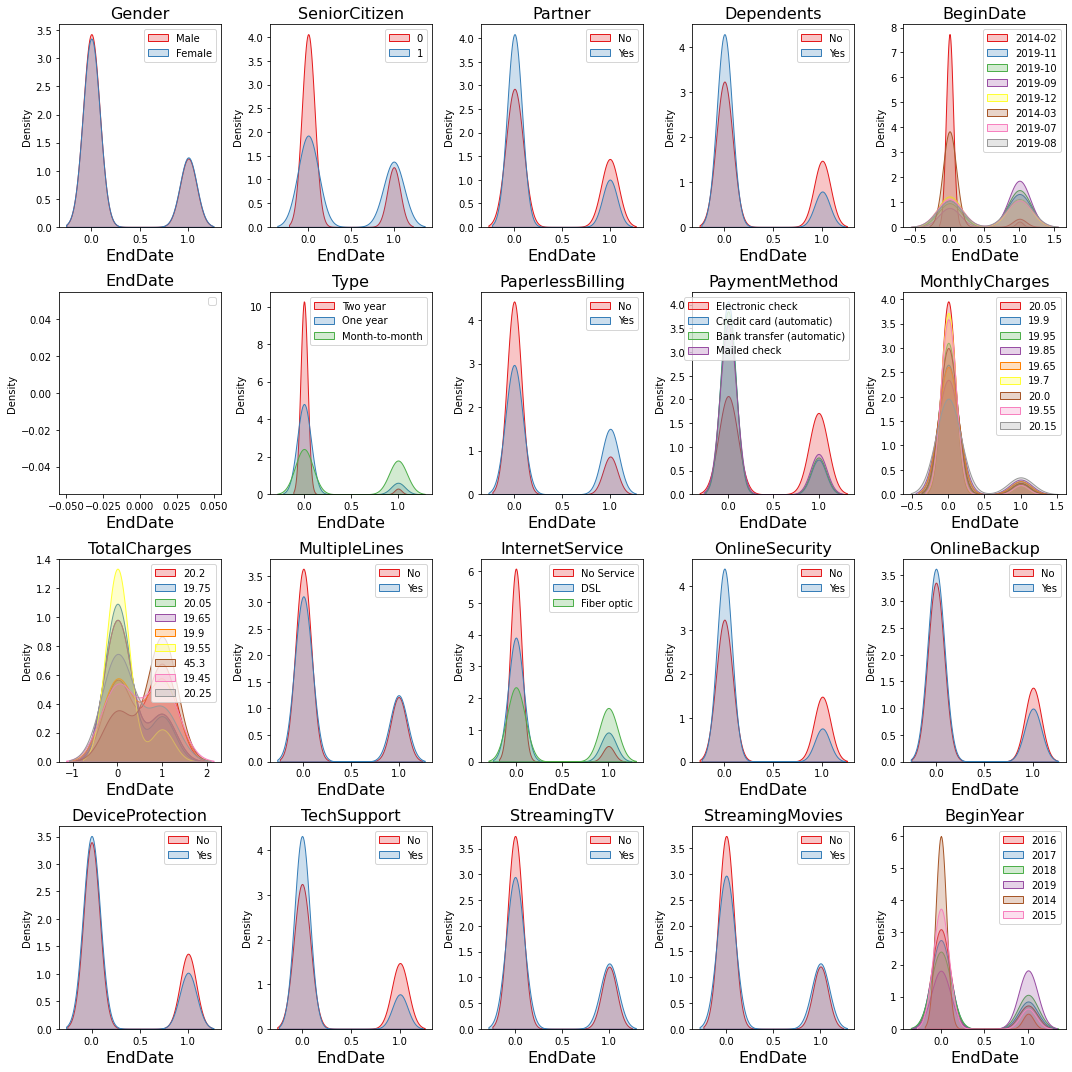

In [26]:
fig, axs = plt.subplots(4, len(df1.columns) // 4, figsize=(15,15))
axs = axs.flatten() #flatten allows for array manipulation to pair subplots with columns via zip

for column, ax in zip(df1.columns, axs):
    display_group_density_plot(df1, groupby = column, on = target, \
                                           palette = sns.color_palette('Set1'), 
                                title=column,
                           figsize = (10, 7), ax=ax)
    ax.legend()


plt.tight_layout()
plt.show()

### Feature Class Distribution in Relation to Target via Density Plot:

Most of the density plots above show small tendencies that contribute towards a customer ending or keeping their plan. For example, it does appear that some of the internet service plans like OnlineSecurity, Online Backup, etc. have a slight tendency for people to stay if they have those services or leave if they don't. There are a few more interesting observations however:

1) There seems to be a stronger connection between electronic check payment method and user's ending their plan. 

2) It does make for month-to-month payments to be the more frequent class to end their plan for the Type feature.

3) We can see that many of the customer's deciding to leave are the newer ones that begin their plan only in the year 2019.

4) For Internet Service, the fiber optic peak's for the 2 classes of the target variable are close in size, meaning customer's who leave tend to have fiber optic.

**Next, we can view the class distribution in relation to the monthly charges**

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


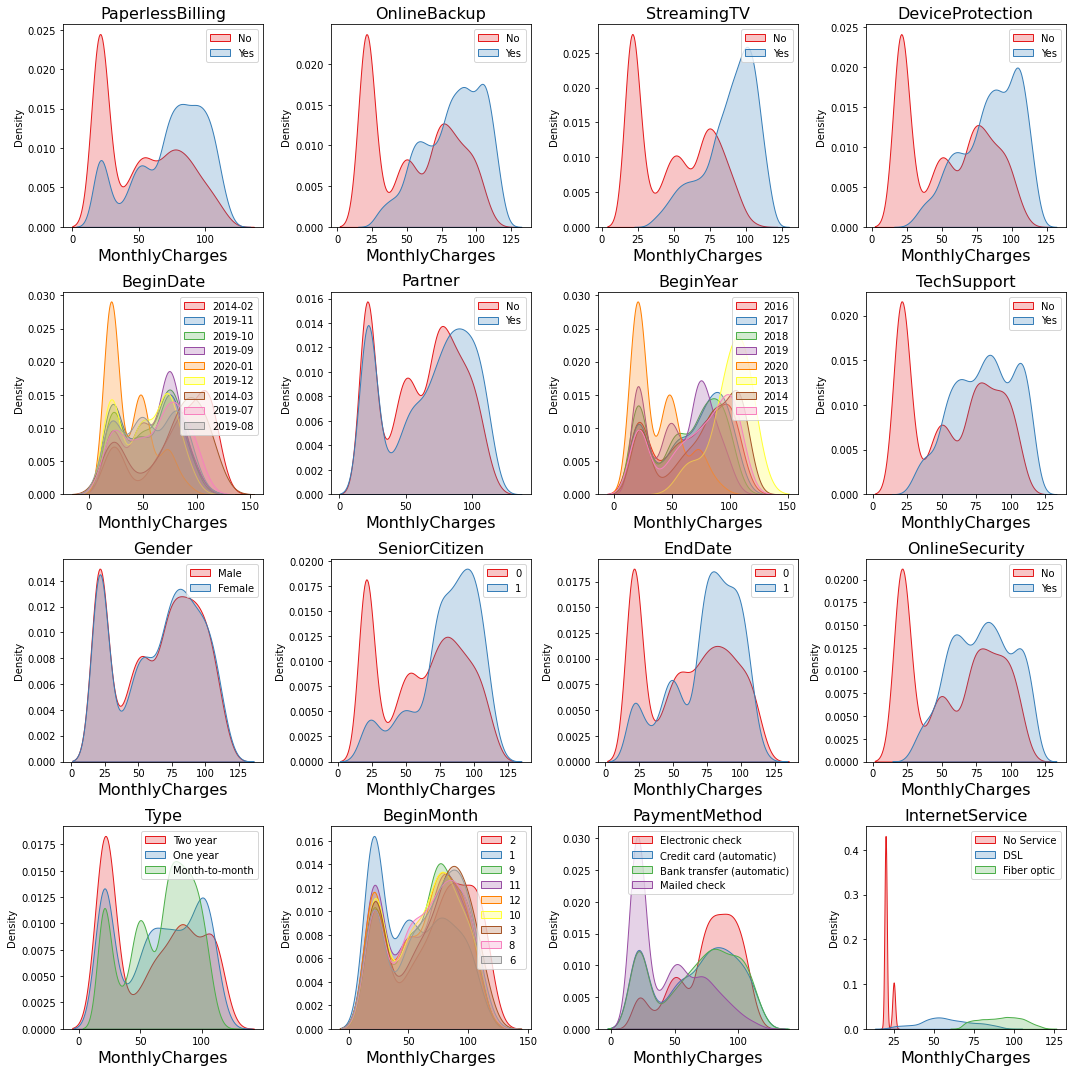

In [27]:
cols = list(set(df1.columns) - set(['MonthlyCharges', 'TotalCharges']))
fig, axs = plt.subplots(4, len(cols) // 4, figsize=(15,15))
axs = axs.flatten()

for cat_col, ax in zip(cols, axs):
    display_group_density_plot(df1, groupby = cat_col, on = 'MonthlyCharges', \
                                           palette = sns.color_palette('Set1'), 
                                title=cat_col,
                           figsize = (10, 5), ax=ax)
    ax.legend()


plt.tight_layout()
plt.show()


### Feature Class Distribution in Relation to Monthly Charges via Density Plot:

1) Month-to-month charges had the highest monthly charges

2) We can see that for extra services like Device Protection, the monthly charges would undestandably be higher.

3) In the BeginYear, we observe that many customers from 2013 have higher monthly charges. This most likely indicates that these older customers enjoy their services and have added more.

4) For InternetService, we can see that fiber optic customers had much higher monthly charges than DSL. This is probably why we saw this more of this class of customers end their plans previously.

5) For the EndDate plot, we clearly see higher monthly charges influencing customer's to end their plans. Those who keep their plan mostly have lower charges.

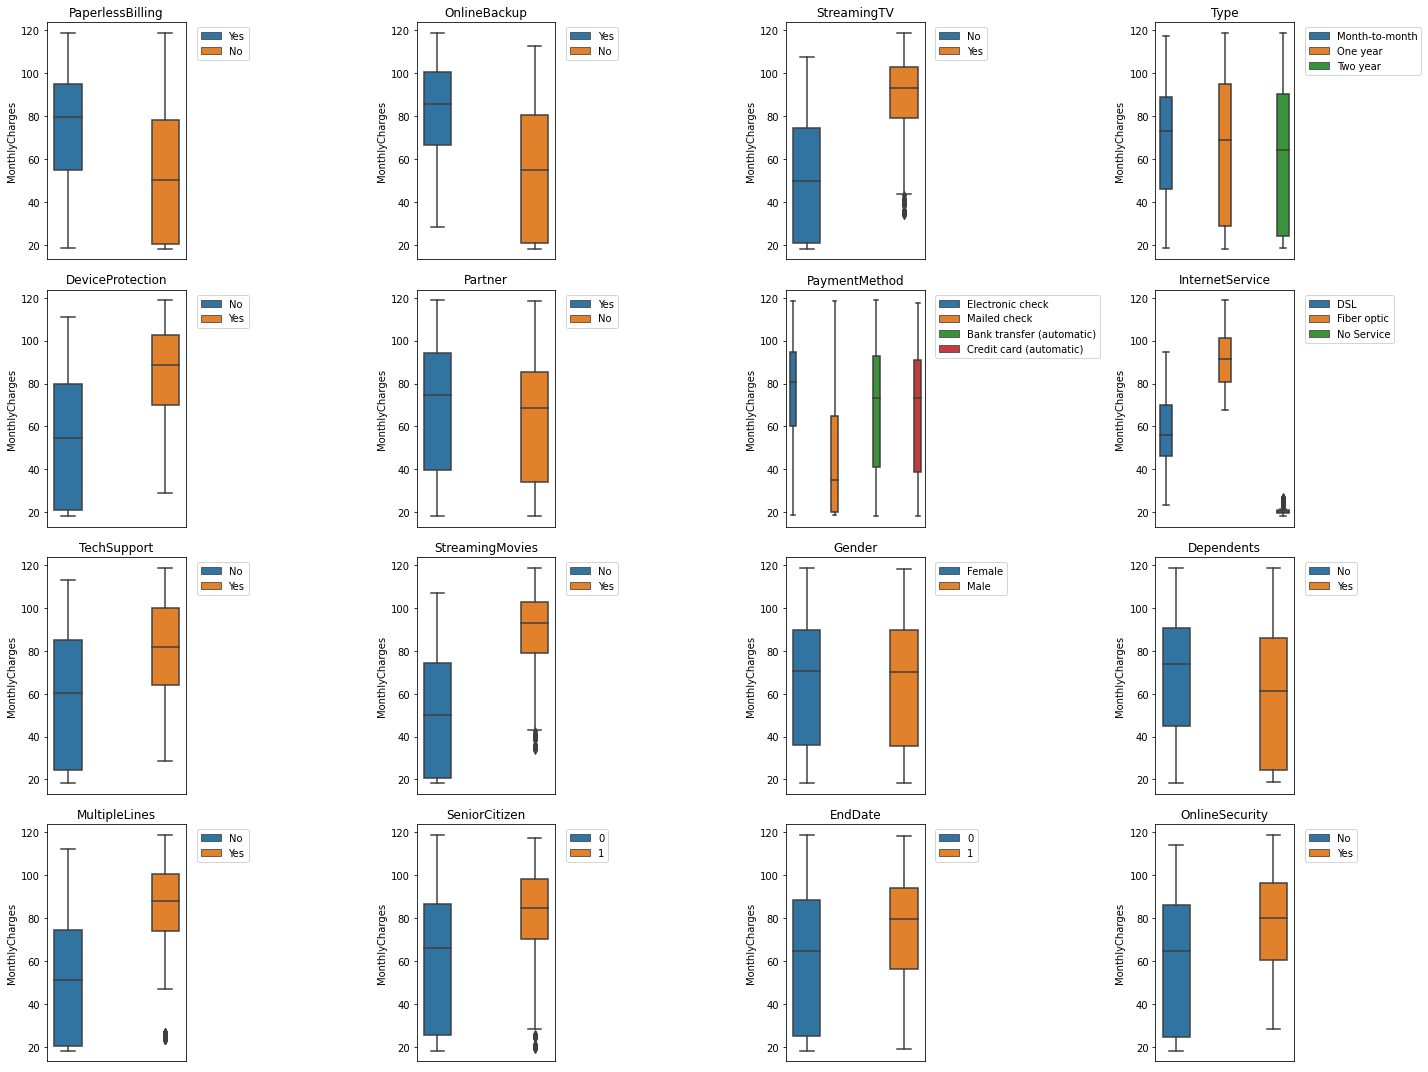

In [28]:
cols = list(set(df1.columns) - set(['MonthlyCharges', 'TotalCharges', 'BeginDate', 'BeginYear', 'BeginMonth']))
fig, axs = plt.subplots(4, len(cols) // 4, figsize=(20,15))
axs = axs.flatten()

for cat_col, ax in zip(cols, axs):
    sns.boxplot(x=cat_col, y='MonthlyCharges', hue=cat_col, data=df1, ax=ax)
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_title(cat_col)


plt.tight_layout()
plt.show()

###  Feature Class Distribution in Relation to Monthly Charges via Boxplot:

1) Distribution all looks normal and able to work with for model training.

## Feature Importance:

**Encoding all categorical columns**

In [29]:
#Dropping BeginDate columns since they are not truly categorical variables

df1 = df1.drop(columns=['BeginDate', 'BeginYear', 'BeginMonth'])
encoders = {}
for column_name in ['Gender', 'Dependents', 'PaperlessBilling', 'PaymentMethod',
                    'DeviceProtection', 'StreamingMovies', 'OnlineBackup', 'TechSupport', 'Partner',
                    'OnlineSecurity', 'StreamingTV', 'MultipleLines', 'InternetService', 'Type',]:
    encoders[column_name] = LabelEncoder()
    df1[column_name] = encoders[column_name].fit_transform(df1[column_name])

df1.head()

,Gender,SeniorCitizen,Partner,Dependents,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,0,0,1,0,0,0,1,2,29.85,29.85,0,0,0,1,0,0,0,0
1,1,0,0,0,0,1,0,3,56.95,1889.50,0,0,1,0,1,0,0,0
2,1,0,0,0,1,0,1,3,53.85,108.15,0,0,1,1,0,0,0,0
3,1,0,0,0,0,1,0,0,42.30,1840.75,0,0,1,0,1,1,0,0
4,0,0,0,0,1,0,1,2,70.70,151.65,0,1,0,0,0,0,0,0


**Now to use feature_importance**

In [30]:
#from sklearn.ensemble import ExtraTreesClassifier
cols = list(df1.columns.values)
cols

['Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'EndDate',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

[0.02742371 0.03098724 0.02476004 0.02375897 0.11252258 0.03218931
 0.07353189 0.20938113 0.24889249 0.02622823 0.05189957 0.02941003
 0.02825842 0.02739288 0.02988755 0.02347597]


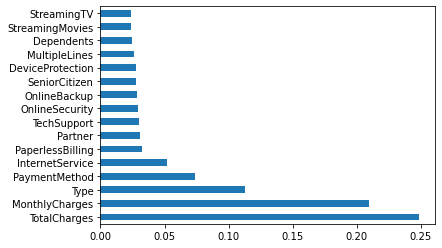

In [31]:
#rearranging the columns so the target is listed lastly
df1 = df1[['SeniorCitizen',
 'Partner',
 'Dependents',
 'StreamingMovies',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'EndDate']]

from sklearn.ensemble import ExtraTreesClassifier
X = df1.iloc[:,0:16]  #independent columns
y = df1.iloc[:,-1]    #target column i.e end date
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(19).plot(kind='barh')
plt.show()



In [32]:
corrmat = df1.corr()
corrmat

,SeniorCitizen,Partner,Dependents,StreamingMovies,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,EndDate
SeniorCitizen,1.000000,0.016957,-0.210550,0.119842,-0.141820,0.156258,-0.038158,0.219874,0.102411,0.142996,-0.032160,-0.038576,0.066663,0.059514,-0.060577,0.105445,0.150541
Partner,0.016957,1.000000,0.452269,0.118108,0.294094,-0.013957,-0.156232,0.097825,0.319072,0.142561,0.000513,0.143346,0.141849,0.153556,0.120206,0.124483,-0.149982
Dependents,-0.210550,0.452269,1.000000,-0.038375,0.240556,-0.110131,-0.041989,-0.112343,0.064653,-0.024307,0.044030,0.080786,0.023639,0.013900,0.063053,-0.016499,-0.163128
StreamingMovies,0.119842,0.118108,-0.038375,1.000000,0.109136,0.211583,-0.154854,0.627235,0.519867,0.259194,-0.250144,0.187426,0.274523,0.402309,0.280155,0.533380,0.060860
Type,-0.141820,0.294094,0.240556,0.109136,1.000000,-0.175475,-0.229636,-0.072739,0.450306,0.107529,0.099579,0.245660,0.155262,0.219648,0.293967,0.104178,-0.396150
PaperlessBilling,0.156258,-0.013957,-0.110131,0.211583,-0.175475,1.000000,-0.061348,0.351930,0.157830,0.163746,-0.138166,-0.004051,0.127056,0.104079,0.037536,0.224241,0.191454
PaymentMethod,-0.038158,-0.156232,-0.041989,-0.154854,-0.229636,-0.061348,1.000000,-0.192500,-0.330594,-0.171240,0.084504,-0.149112,-0.170720,-0.180931,-0.156296,-0.148563,0.107852
MonthlyCharges,0.219874,0.097825,-0.112343,0.627235,-0.072739,0.351930,-0.192500,1.000000,0.651065,0.490912,-0.322173,0.296447,0.441529,0.482607,0.338301,0.629668,0.192858
TotalCharges,0.102411,0.319072,0.064653,0.519867,0.450306,0.157830,-0.330594,0.651065,1.000000,0.469042,-0.175691,0.412619,0.510100,0.522881,0.432868,0.515709,-0.199484
MultipleLines,0.142996,0.142561,-0.024307,0.259194,0.107529,0.163746,-0.171240,0.490912,0.469042,1.000000,0.011346,0.098592,0.202228,0.201733,0.100421,0.257804,0.040033


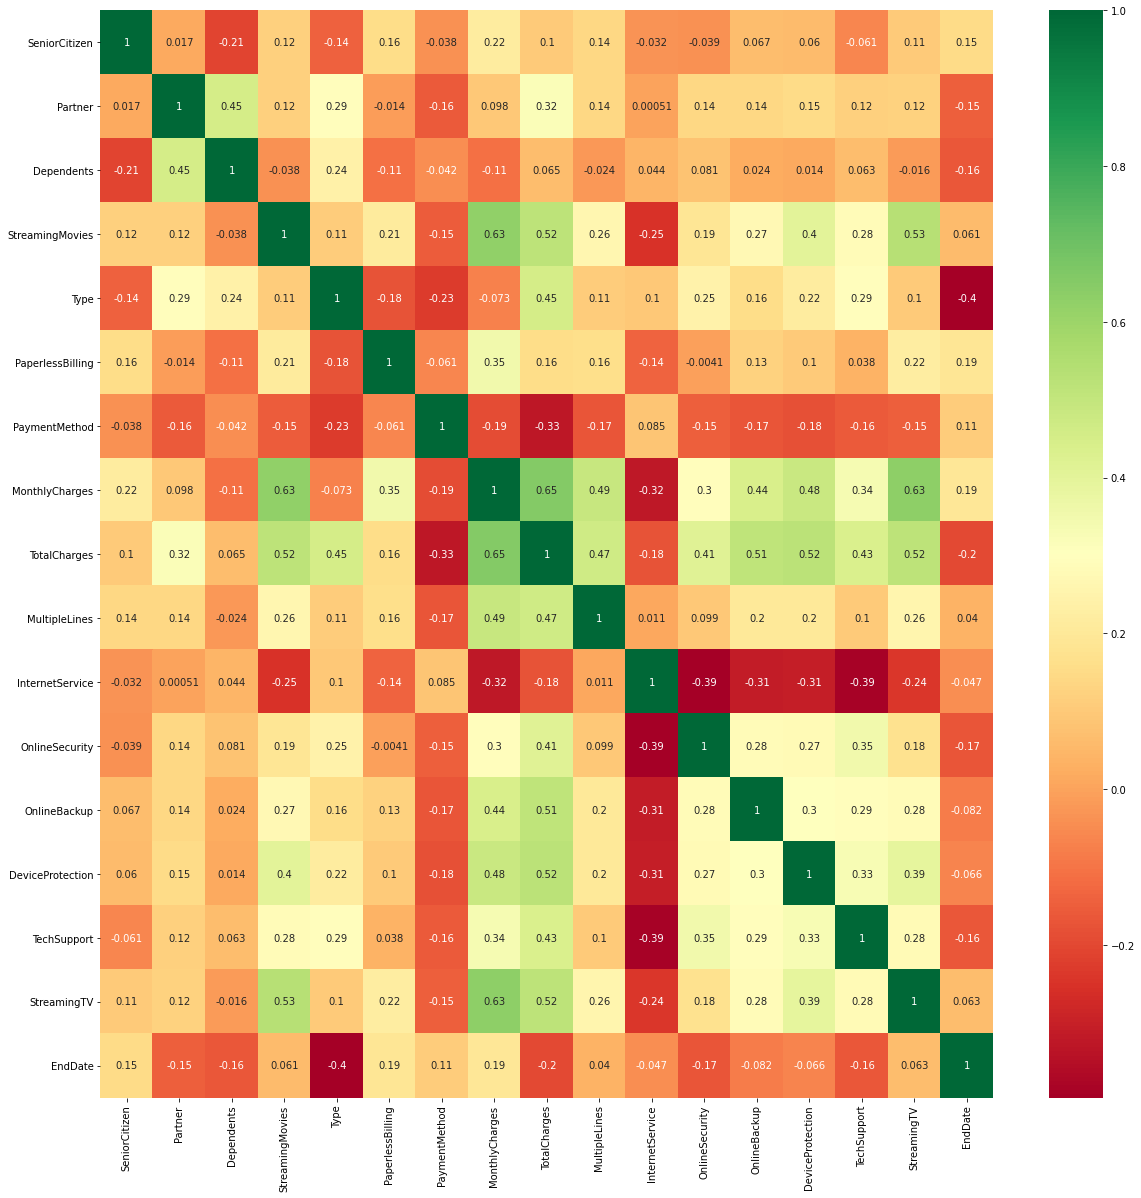

In [33]:
#Visualizing correlation as heat map
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df1[top_corr_features].corr(),annot=True,cmap="RdYlGn")

#### Feature Selection Conclusion:

1) The most influential features are: Total Charges, Monthly Charges, Type, Internet Service, and Payment Method.

## Model Training

In [34]:
def class_report(y_true, y_pred):
    display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T)

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

In [35]:
X = df1.drop(columns=['EndDate'], axis=1)
y = df1['EndDate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12345)

In [36]:
numeric_cols = ['TotalCharges', 'MonthlyCharges']
scaler = StandardScaler()
scaler.fit(X_train[numeric_cols])
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

/tmp/ipykernel_390/4252759816.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_390/4252759816.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

          train  test
Accuracy   0.74  0.71
F1         0.00  0.00
APS        0.26  0.29
ROC AUC    0.50  0.50


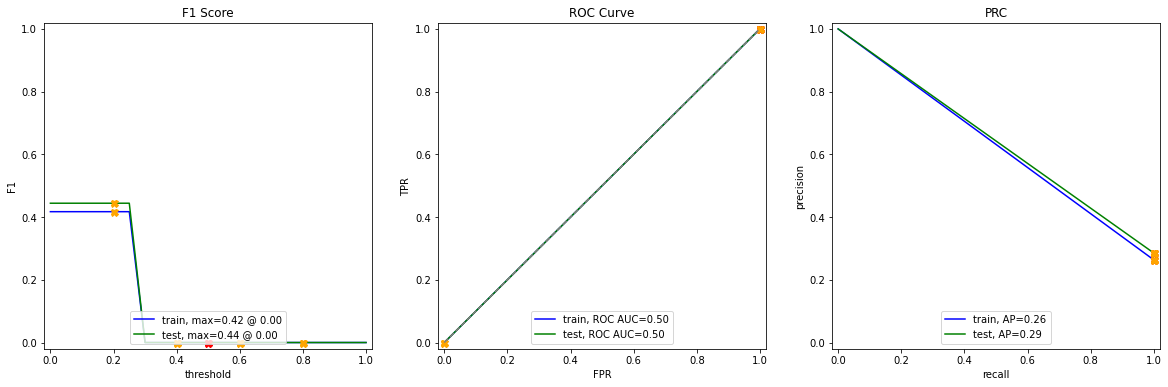

In [37]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
dummy_clf.predict(X_train)
#dummy_clf.score(X_train, y_train)
evaluate_model(dummy_clf, X_train, y_train, X_test, y_test)

### Logistic Regression Model

          train  test
Accuracy   0.80  0.78
F1         0.56  0.56
APS        0.63  0.66
ROC AUC    0.83  0.84


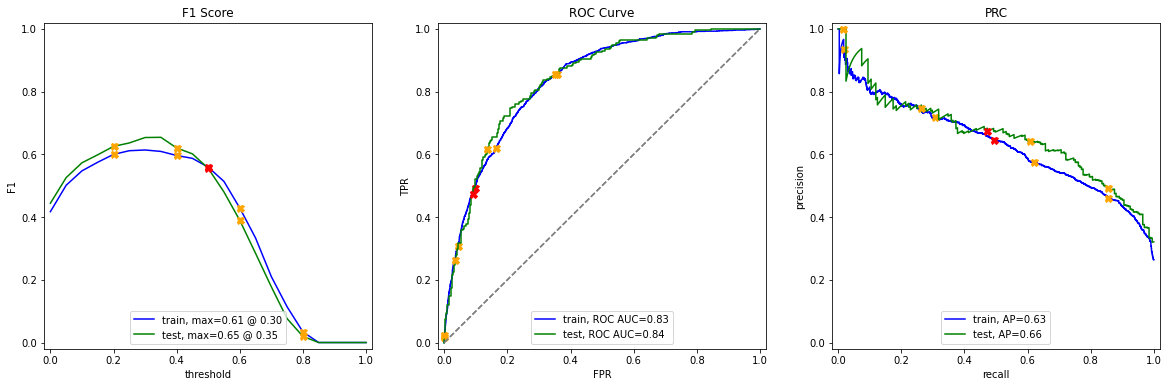

In [38]:
lr = LogisticRegressionCV(cv=5, random_state=12345).fit(X_train, y_train)
y_pred = lr.predict(X_test)
evaluate_model(lr, X_train, y_train, X_test, y_test)

In [39]:
class_report(y_test, y_pred)

,precision,recall,f1-score,support
0,0.811723,0.908549,0.857411,503.000000
1,0.673759,0.472637,0.555556,201.000000
accuracy,0.784091,0.784091,0.784091,0.784091
macro avg,0.742741,0.690593,0.706483,704.000000
weighted avg,0.772333,0.784091,0.771228,704.000000


### Decision Tree Model

In [40]:
params = {
'criterion':['gini', 'entropy'],
'max_depth':[2,4,8,16],
'min_samples_split':[2,4,8, 16],
'min_samples_leaf':[2,4,6]}
clf = GridSearchCV(DecisionTreeClassifier(), params, cv=5).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.score(X_train, y_train))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
class_report(y_test, y_pred)

0.7907711757269279
0.7855113636363636
[[462  41]
 [110  91]]


,precision,recall,f1-score,support
0,0.807692,0.918489,0.859535,503.000000
1,0.689394,0.452736,0.546547,201.000000
accuracy,0.785511,0.785511,0.785511,0.785511
macro avg,0.748543,0.685613,0.703041,704.000000
weighted avg,0.773917,0.785511,0.770173,704.000000


0.7907711757269279
0.7855113636363636
[[462  41]
 [110  91]]


,precision,recall,f1-score,support
0,0.807692,0.918489,0.859535,503.000000
1,0.689394,0.452736,0.546547,201.000000
accuracy,0.785511,0.785511,0.785511,0.785511
macro avg,0.748543,0.685613,0.703041,704.000000
weighted avg,0.773917,0.785511,0.770173,704.000000


          train  test
Accuracy   0.79  0.79
F1         0.54  0.55
APS        0.59  0.63
ROC AUC    0.83  0.84


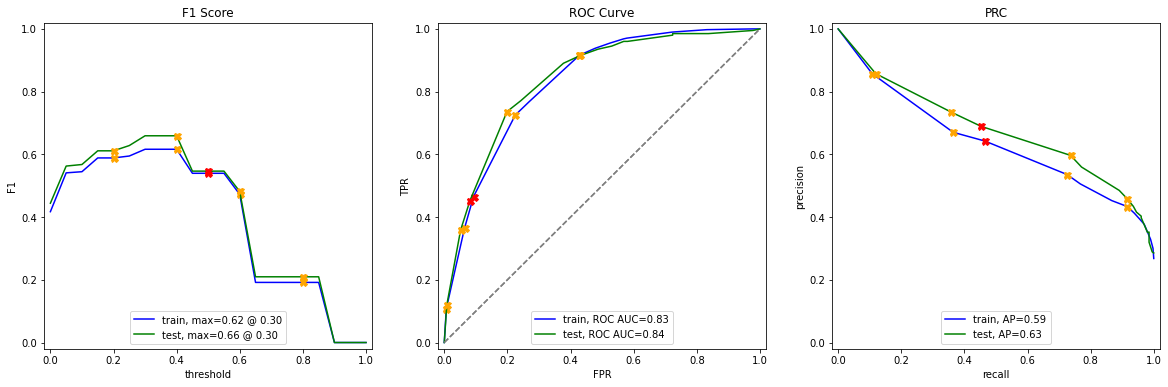

In [41]:
dt = DecisionTreeClassifier(**clf.best_params_).fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(dt.score(X_train, y_train))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
class_report(y_test, y_pred)
evaluate_model(dt, X_train, y_train, X_test, y_test)

### Catboost Model

In [42]:
pool_train = Pool(X_train, y_train,
                  cat_features = ['SeniorCitizen', 'Partner', 'Dependents', 'StreamingMovies', 'Type', 'PaperlessBilling', 
                                  'PaymentMethod', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                                  'DeviceProtection', 'TechSupport', 'StreamingTV'])

pool_test = Pool(X_test, cat_features = ['SeniorCitizen', 'Partner', 'Dependents', 'StreamingMovies', 'Type', 'PaperlessBilling', 
                                  'PaymentMethod', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                                  'DeviceProtection', 'TechSupport', 'StreamingTV'])

Learning rate set to 0.02265
0:	learn: 0.6779256	total: 59.6ms	remaining: 59.5s
1:	learn: 0.6641218	total: 69.5ms	remaining: 34.7s
2:	learn: 0.6507222	total: 80.7ms	remaining: 26.8s
3:	learn: 0.6375971	total: 95.1ms	remaining: 23.7s
4:	learn: 0.6248123	total: 104ms	remaining: 20.8s
5:	learn: 0.6141429	total: 111ms	remaining: 18.4s
6:	learn: 0.6042383	total: 120ms	remaining: 17s
7:	learn: 0.5942475	total: 128ms	remaining: 15.9s
8:	learn: 0.5855041	total: 138ms	remaining: 15.2s
9:	learn: 0.5764513	total: 150ms	remaining: 14.8s
10:	learn: 0.5680681	total: 163ms	remaining: 14.7s
11:	learn: 0.5604357	total: 171ms	remaining: 14.1s
12:	learn: 0.5531145	total: 179ms	remaining: 13.6s
13:	learn: 0.5458175	total: 187ms	remaining: 13.2s
14:	learn: 0.5402608	total: 195ms	remaining: 12.8s
15:	learn: 0.5341690	total: 202ms	remaining: 12.4s
16:	learn: 0.5285148	total: 210ms	remaining: 12.1s
17:	learn: 0.5228164	total: 222ms	remaining: 12.1s
18:	learn: 0.5173874	total: 235ms	remaining: 12.1s
19:	learn:

,precision,recall,f1-score,support
0,0.808772,0.916501,0.859273,503.000000
1,0.686567,0.457711,0.549254,201.000000
accuracy,0.785511,0.785511,0.785511,0.785511
macro avg,0.747670,0.687106,0.704263,704.000000
weighted avg,0.773881,0.785511,0.770759,704.000000


          train  test
Accuracy   0.84  0.79
F1         0.65  0.55
APS        0.77  0.69
ROC AUC    0.90  0.85


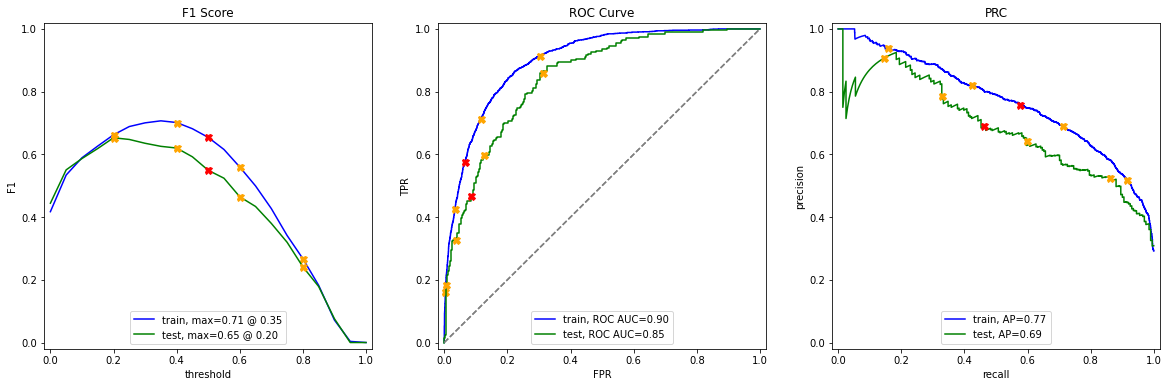

In [43]:
cb = CatBoostClassifier()
cb.fit(pool_train)
y_pred = cb.predict(pool_test)
print(cb.score(X_train, y_train))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
class_report(y_test, y_pred)
evaluate_model(cb, X_train, y_train, X_test, y_test)


## Report Summary

In the report, please answer the following questions:

**1) What steps of the plan were performed and what steps were skipped (explain why)?**

In completion of this project, there were a few steps that were altered or rearranged. The original plan was to do data preprocessing and then move to exploratory data analysis, however this was switched because it would have been more beneficial to the company to understand all the features. If data preprocessing was performed first, many features would not have been analyzed because they would have been dropped as part of preprocesssing for model training.

As a result of this decision, many of the preprocessing steps that would have been skipped to "save time", such as NaN's, were still included for the sake of data exploration.

**2) What difficulties did you encounter and how did you manage to solve them?**

I came across some difficulties when it came time to improve my catboost model. I wanted to perform hyperparameter tuning however I was not sure how to install/utilize a GPU. Thankfully, the catboost model itself was good enough to achieve the 0.85 AUC-ROC score. Hyperparameter tuning through GPU is something I would like to implement to improve this project.

A more general problem was trying to decide whether to deviate from my original work plan to improve the exploratory data analysis process. It does not show in the code, but I spent a lot of time thinking about how to organize each step. I believe I chose the right thing to alter my plan because more information became available to the company by including features I would have dropped through feature importance selection.

Lastly, I decided to include all features instead of only including the ones highlighted from feature importance for model training. This was decided because according to the heatmap, the correlation between the stronger features and the target was not high enough to simply omit the other features.


**3) What were some of the key steps to solving the task?**

The data preprocessing and the model training and evaluation were the key steps to solving this task. Thorough data preprocessing heavily contributes to model performance while the model training step itself was the main solution to the task.

**4) What is your final model and what quality score does it have?**

The final model was a simple catboost model without any hyperparameter tuning. This was made possible because of the accurate data preprocessing. The quality score it achieved was 0.85 ROC AUC score.


Here are some of the criteria used by the team leader:
Did you answer all the questions?
Are the answers clear?